In [2]:
import sys

import numpy as np
import pandas as pd
from dtaidistance import dtw
from matplotlib import pyplot as plt

sys.path.append('../../../')

**Import Files**

In [3]:
model_output_csv_path = "../../../data/model_output/start_2023-11-21T17-37-01.696+00-00.csv"

model_detections = pd.read_csv(model_output_csv_path, delimiter=",")

ground_truth_csv = "../../../data/labels/start_2023-11-21T17-37-01.696+00-00_ground_truth.csv"

ground_truth = pd.read_csv(ground_truth_csv, delimiter=",")

value_counts_model = pd.DataFrame(model_detections.id.value_counts()).reset_index().rename(columns={"index": "id", "id": "occurences"})

value_counts_truth =  pd.DataFrame(ground_truth.id.value_counts()).reset_index().rename(columns={"index": "id", "id": "occurences"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


64it [00:02, 24.67it/s]


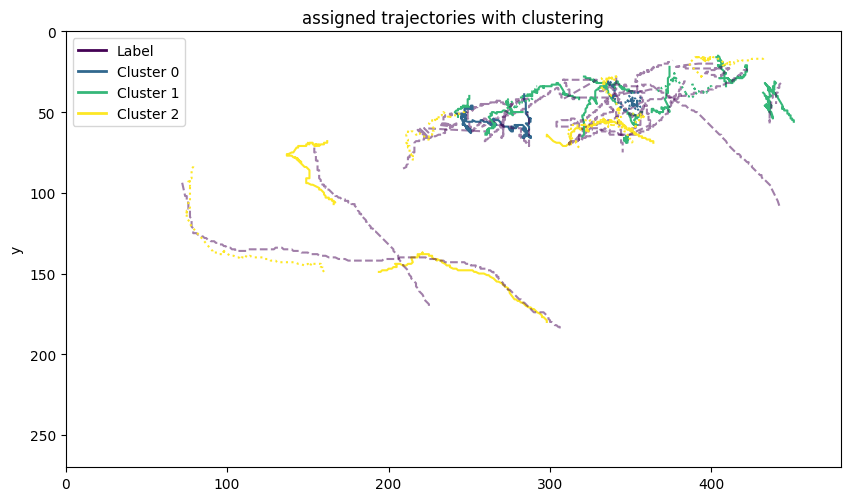

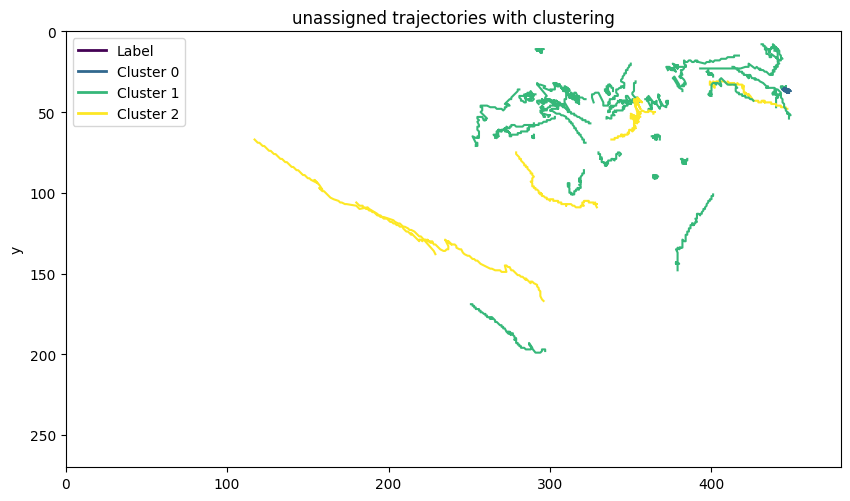

({111: 251,
  963: 252,
  2087: 253,
  3574: 256,
  3586: 255,
  3935: 257,
  4095: 258,
  4119: 260,
  5291: 262,
  6621: 263,
  7330: 264,
  8050: 266,
  9088: 267,
  9284: 268,
  9548: 269,
  10597: 270},
 {367: 251,
  634: 252,
  3825: 258,
  4644: 260,
  6922: 264,
  8239: 266,
  8509: 267,
  9867: 269})

In [13]:
%load_ext autoreload
%autoreload 2
from sklearn.cluster import KMeans

from analysis.features import FeatureGenerator

gen = FeatureGenerator(
    measurements_csv_paths=[model_output_csv_path], 
    gt_csv_paths=[ground_truth_csv], 
    min_track_length=60, 
    force_feature_recalc=True,
    rake_mask_path="../../demo/masks/stroppel_rake_front_mask.png",
)
gen.do_clustering(
    features=['traversed_distance', 'frame_diff'],
    clustering_method=KMeans, 
    n_clusters=3,
)
gen.plot_track_pairings()

# TODO: merge chris stuff and visualize paths with different feature values
# TODO: do quantitative analysisand select thresholds for the features

# Compare features and patches

In [122]:
import ast

mmt_df = gen.mmt_dfs[0].copy()
# parse image_tile column to array
mmt_df['image_tile'] = mmt_df['image_tile'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.int32))

In [187]:
import cv2 as cv

def histogram(patch: np.ndarray):
    hist_raw = np.histogram(patch, bins=range(257))[0].reshape(-1, 1).astype(np.float32)
    hist_raw[127, 0] = 0.0 # remove the background bin
    return cv.normalize(hist_raw, hist_raw, alpha=0, beta=1, norm_type=cv.NORM_MINMAX).reshape(-1)

def sift_features(patch: np.ndarray):
    patch_uint8 = (patch * 255).astype(np.uint8)  # convert to 8-bit unsigned integer
    return cv.SIFT_create().detectAndCompute(patch_uint8, None)

def fft(patch: np.ndarray):
    patch = np.squeeze(patch)
    patch_uint8 = (patch * 255).astype(np.uint8)  # convert to 8-bit unsigned integer
    # patch_uint8 = cv.resize(patch_uint8, (64, 64))
    if patch_uint8.shape[0] < 3 or patch_uint8.shape[1] < 3:
        return []
    else:
        fft = np.fft.fft2(patch_uint8)
        return fft

# calculate features for mmts
mmt_df['histogram'] = mmt_df['image_tile'].apply(histogram)
mmt_df['fft'] = mmt_df['image_tile'].apply(fft)

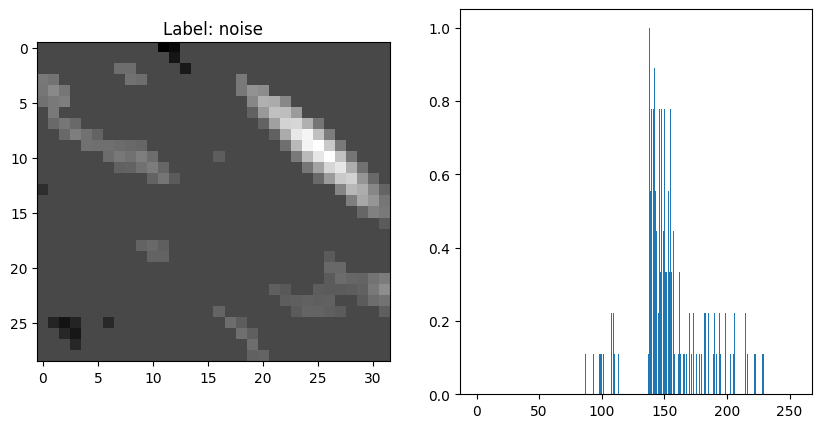

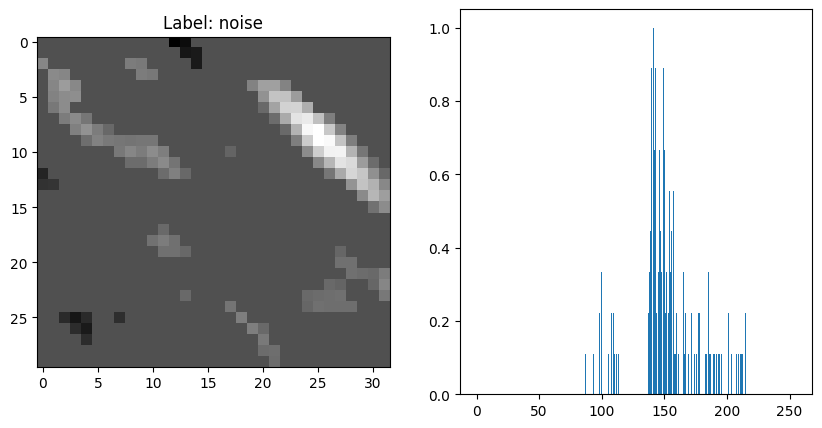

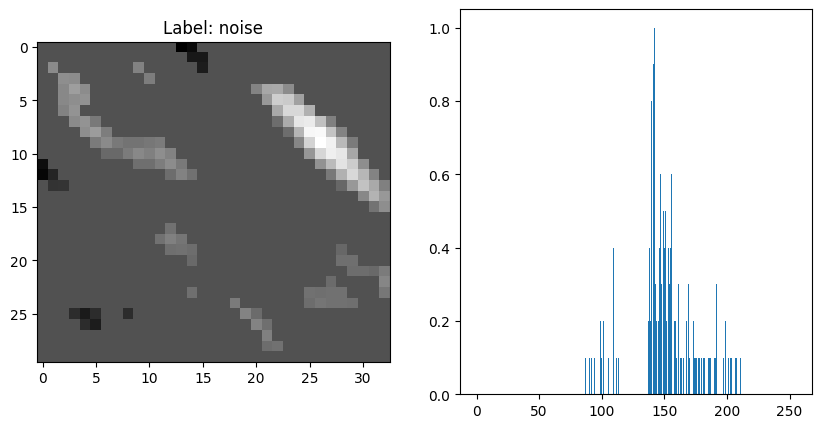

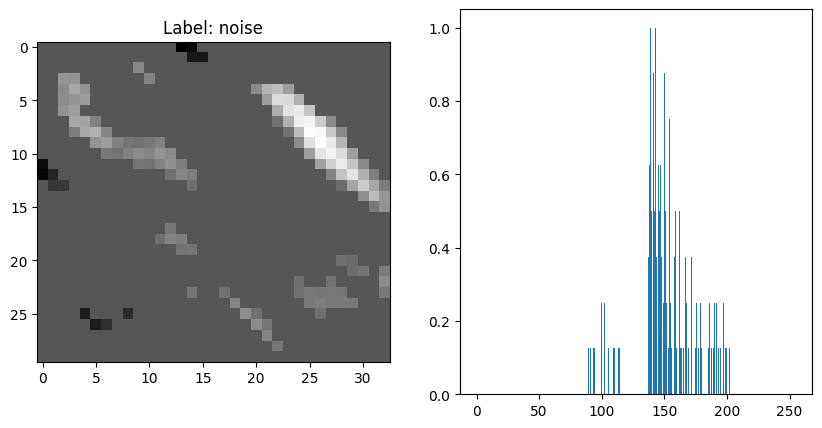

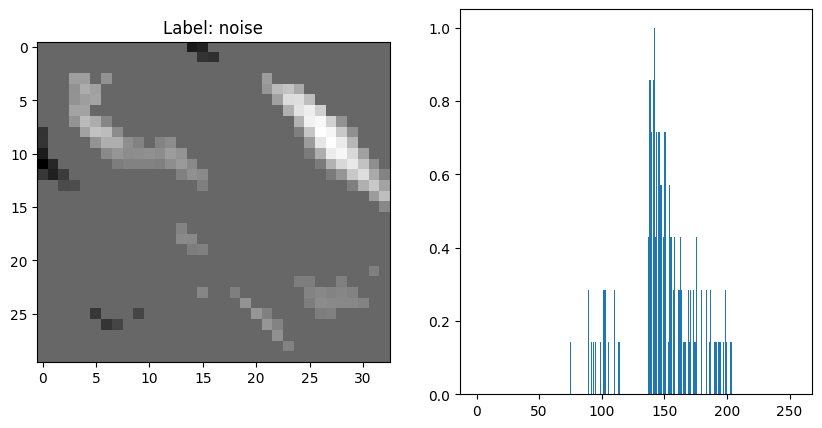

In [206]:
gen.measurements[0]

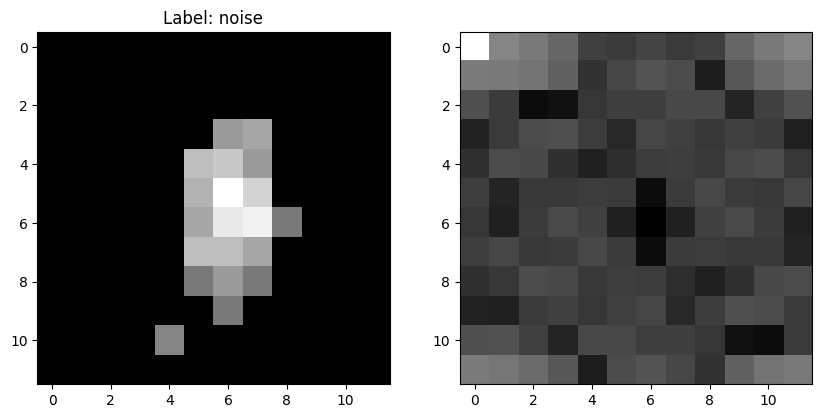

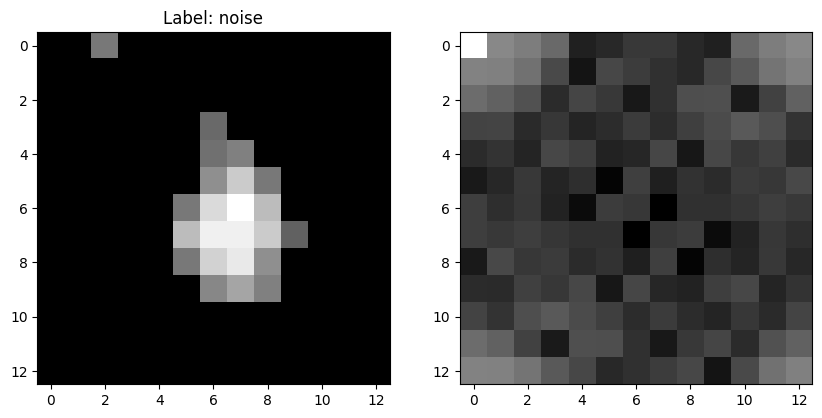

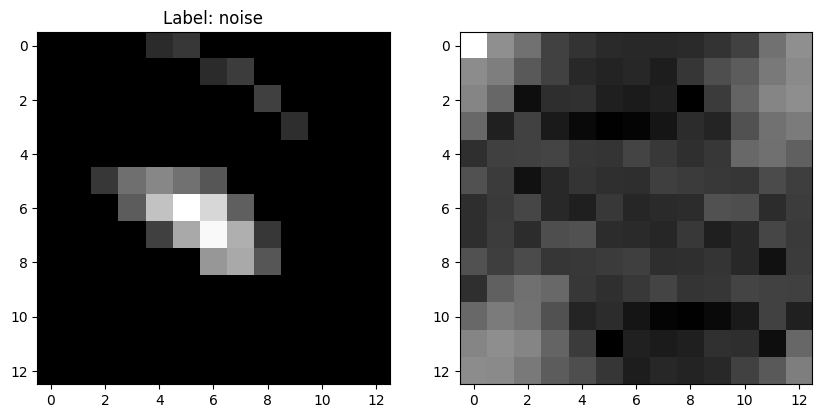

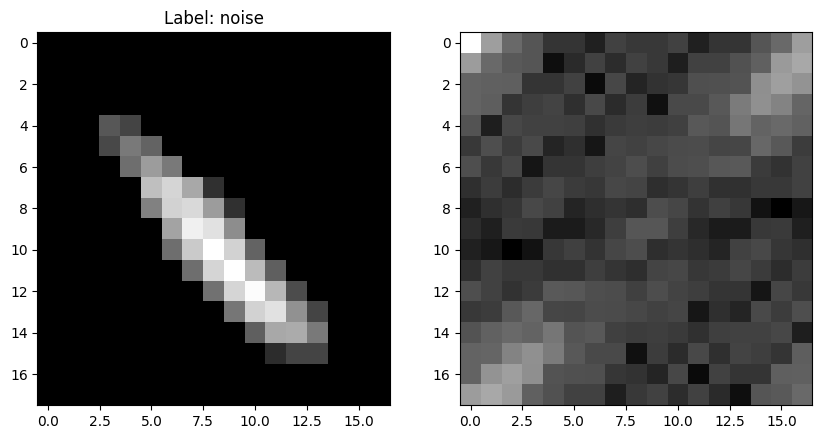

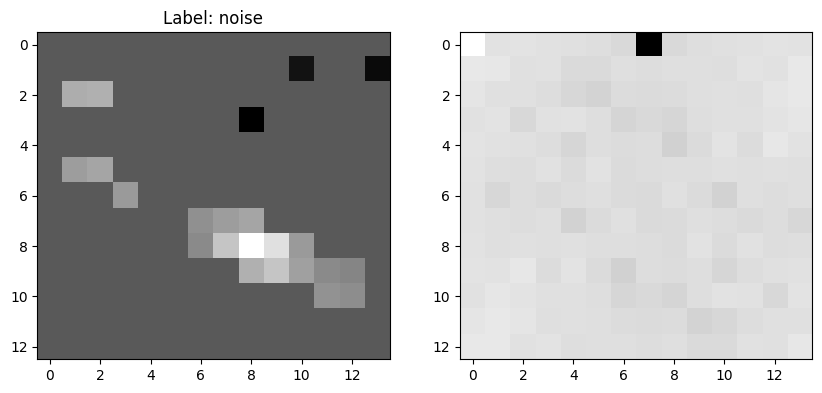

In [192]:
# plot some random patches with their ffts
for idx in indices:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    image_tile = np.squeeze(mmt_df.loc[idx, 'image_tile'])
    label = mmt_df.loc[idx, 'gt_label']
    ax[0].set_title(f'Label: {label}')
    ax[0].imshow(image_tile, cmap='gray')  # use grayscale colormap
    ax[1].imshow(np.log(np.abs(mmt_df.loc[idx, 'fft'])), cmap='gray')  # use grayscale colormap
    plt.show()

In [ ]:
# logistic regression based on some features

**PLOT PATHS**

In [43]:
def plot_path(identifier, data, alpha, color):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data.loc[data.id == identifier, "x"], data.loc[data.id == identifier, "y"], alpha=alpha, color=color)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [135]:
identifier_counts = model_detections.id.value_counts()

In [136]:
filtered_df = model_detections[model_detections['id'].isin(identifier_counts[identifier_counts >= 20].index)]

In [137]:
filtered_twice = filtered_df
#filtered_twice = filtered_df[filtered_df['id'].isin(identifier_counts[identifier_counts <= 360].index)]

In [138]:
def get_path(identifier, data):
    return data.loc[data.id == identifier, ["x", "y"]].to_numpy()

paths = []
paths_identifiers = []

for identifier in filtered_twice["id"].unique():
    path = get_path(identifier, filtered_df)
    paths.append(path)
    paths_identifiers.append(identifier)


In [139]:
paths_identifiers

[483,
 1619,
 1683,
 1970,
 2427,
 2688,
 2693,
 2760,
 2871,
 2875,
 2984,
 3062,
 3064,
 3229,
 3242,
 3514,
 3674,
 4042,
 4474,
 4760,
 5231,
 5640,
 5768,
 5799,
 5904,
 5936,
 6110,
 6326,
 6735,
 7011,
 7082,
 7312,
 7602,
 7950,
 8572,
 8807,
 8988,
 9362,
 9389,
 9420,
 9500,
 9612,
 9619,
 9689,
 9692,
 9712,
 9747,
 9765,
 10193,
 10281,
 10588,
 10695,
 10760,
 10780,
 11263,
 11579,
 12307,
 12394,
 12484,
 12931,
 12943]

In [140]:
def z_standardize(path):
    mean = np.mean(path, axis=0)
    std = np.std(path, axis=0)
    return (path - mean) / std

In [141]:
standardized_paths = [z_standardize(path) for path in paths]

In [142]:
from dtaidistance import dtw_ndim

from dtaidistance import dtw, clustering


In [143]:
hier = clustering.Hierarchical(dtw_ndim.distance_matrix, dists_options={"window": 40})

In [144]:
hier_tree = clustering.HierarchicalTree(hier)

In [145]:
fitting_result = hier_tree.fit(standardized_paths)

In [73]:
fitting_result

{0: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34}}

In [146]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [147]:
from scipy.cluster.hierarchy import dendrogram

In [148]:
len(paths)

61

In [149]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [2]:
plt.figure(figsize=(25, 10))

dendrogram(hier_tree.linkage, labels=filtered_twice["id"].unique(), truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, )
plt.savefig('wat.png')


NameError: name 'plt' is not defined

In [79]:
wat = clustering.KMeans(k=2).fit(standardized_paths)

{}
14.874085979527512


In [80]:
wat

({0: {0,
   2,
   3,
   4,
   6,
   7,
   8,
   10,
   12,
   13,
   15,
   16,
   17,
   20,
   21,
   23,
   24,
   26,
   27,
   28,
   29,
   31,
   32,
   33},
  1: {1, 5, 9, 11, 14, 18, 19, 22, 25, 30, 34}},
 3)

In [151]:
medoids = clustering.KMedoids(dtw_ndim.distance_matrix, dists_options={"window": 40}, k=2)

In [152]:
med_result = medoids.fit(standardized_paths)

In [153]:
med_result

{10: {2,
  3,
  5,
  7,
  10,
  11,
  13,
  14,
  17,
  18,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  33,
  37,
  38,
  39,
  42,
  46,
  47,
  52,
  56,
  57,
  59},
 32: {0,
  1,
  4,
  6,
  8,
  9,
  12,
  15,
  16,
  19,
  20,
  21,
  22,
  28,
  31,
  32,
  34,
  35,
  36,
  40,
  41,
  43,
  44,
  45,
  48,
  49,
  50,
  51,
  53,
  54,
  55,
  58,
  60}}

In [154]:
med_result.keys()

dict_keys([10, 32])

In [155]:
new_fish = []
clusters = wat[0]
for i, identifier in enumerate(paths_identifiers):
    if i in clusters.get(1, []):
        new_fish.append(identifier)

In [224]:
def plot_path_numpy(data, alpha, color, text=""):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data[:,0], data[:,1], alpha=alpha, color=color)
    plt.text(x = data[0,0],y = data[0,1],s=text)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [171]:
%matplotlib widget


In [225]:
plt.close()

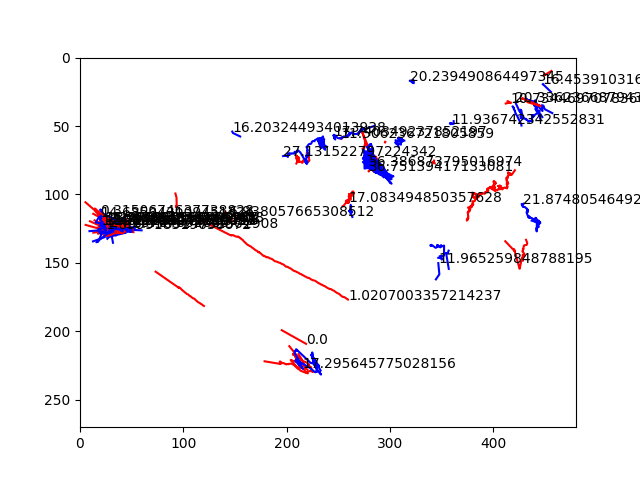

In [226]:
clusters = med_result
#clusters = wat[0]
for i in range(0, len(paths)):
    if i in clusters.get(10):
        color = "red"
    if i in clusters.get(32):
        color = "blue"
    #if i in clusters.get(0, []):
    #    color = "red"
    #if i in clusters.get(1, []):
    #    color = "blue"
    #if i in clusters.get(2, []):
    #    color = "green"
    #if i in clusters.get(3, []):
    #    color = "yellow"
    distance = dtw_ndim.distance(standardized_paths[i], standardized_paths[10], window=40)  if i % 2== 0 else ""
   # distance = ""

    plot_path_numpy(paths[i], 1, color, distance)

In [174]:
plot_path_numpy(paths[10], 1, "yellow")

In [ ]:
plot_path_numpy(paths[53], 1, "red")

In [ ]:
plot_path_numpy(paths[14], 0.2, "blue")

In [ ]:
standardized_paths[14]

In [ ]:
plt.plot(standardized_paths[14][:,0], standardized_paths[14][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(standardized_paths[15][:,0], standardized_paths[15][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(ground_truth["x"], ground_truth["y"], alpha=alpha, color=fish_color)


In [ ]:
len(paths)

In [ ]:
get_path(13410, model_detections)

In [ ]:
path = model_detections[model_detections['id']==13410][["x", "y"]].to_numpy()

In [ ]:
another_path = model_detections[model_detections['id']==14868][["x", "y"]].to_numpy()


In [ ]:
another_path.shape

In [ ]:
dtw_ndim.distance(path, another_path)

In [ ]:
dtw_ndim.distance(path, path)


In [ ]:
path.shape

In [ ]:
import numpy as np

In [ ]:
series1 = np.array([[0, 0],  # first point at t=0
                    [0, 1],  # second point at t=1
                    [2, 1],
                    [0, 1],
                    [0, 0]], dtype=np.double)


## Tested until here with new code

In [ ]:
few_fish_night_csv = "v2_output_02-23.csv"
many_fish_afternoon_csv = "v2_output_16-46.csv"
few_fish = pd.read_csv(few_fish_night_csv, delimiter=",")
many_fish = pd.read_csv(many_fish_afternoon_csv, delimiter=",")

value_counts_few = pd.DataFrame(few_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})
value_counts_many = pd.DataFrame(many_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})

In [ ]:
# value_counts_few.plot.bar(x='ID', y='occurences')
value_counts_few.head(200)

In [ ]:
amount = 100
alpha = 0.3
fish_color = "red"
object_color = "grey"

fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1, sharex=True,  figsize=(10, 10))
plt.gca().invert_yaxis()

data = few_fish
for object in value_counts_few.ID.tolist()[:amount]:
    color = object_color
    ax.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)

data = many_fish
for object in value_counts_many.ID.tolist()[:amount]:
    color = object_color
    ax1.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)


ax.set(ylabel='y',
       title="no fish \n" + few_fish_night_csv, ylim=[270, 0], xlim=[0, 480])
ax1.set(xlabel='x', title="many fish \n" + many_fish_afternoon_csv, ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')
ax1.set_aspect('equal', adjustable='box')
fig.suptitle(f"Paths of {amount} longest lasting objects", fontsize=14)

line1 = ax.plot([],[], color=fish_color, label='Fish')
line2 = ax.plot([],[], color=object_color, label='Object')
ax.legend()
line1 = ax1.plot([],[], color=fish_color, label='Fish')
line2 = ax1.plot([],[], color=object_color, label='Object')
ax1.legend()

plt.show()

In [ ]:
many_fish_min_50 = many_fish.loc[many_fish.ID.isin(value_counts_many.loc[value_counts_many["occurences"]>50, "ID"])]

In [ ]:
many_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=50)

In [ ]:
few_fish_min_50 = few_fish.loc[few_fish.ID.isin(value_counts_few.loc[value_counts_few["occurences"]>50, "ID"])]

In [ ]:
few_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=30)